In [1]:
import numpy as np

In [2]:
def extractPoseHand(npy):
    np_matrix=npy.reshape(-1,1629)
    # arr = []
    # print(np_matrix.shape)
    pose  = np_matrix[: ,0:99]
    hands  = np_matrix[: ,1503:1629]
    
 
    arr = np.concatenate((pose, hands), axis=1)


      
    return arr

In [3]:
import random
import os
import numpy as np

crossValidationDataPaths=['RELATIVE_QUANT_D5MAX/Training/RightHand','RELATIVE_QUANT_D5MAX/Training/LeftHand']
testPaths=['RELATIVE_QUANT_D5MAX/Test/RightHand','RELATIVE_QUANT_D5MAX/Test/LeftHand']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    # npy_matrix=npy.reshape(-1,1629)
   
    npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    

test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    # npy_matrix=npy.reshape(-1,1629)

    npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [4]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 64
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,225) # pose hands



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)

2024-01-05 17:43:44.448973: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 17:43:44.469281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 17:43:44.469298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 17:43:44.469809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 17:43:44.473260: I tensorflow/core/platform/cpu_feature_guar

[52, 39, 17, 21, 48, 40, 27, 59, 17, 0, 14, 7, 58, 53, 46, 32, 45, 8, 43, 1, 46, 14, 19, 48, 51, 44, 31, 12, 8, 9, 8, 6, 13, 4, 39, 20, 18, 42, 27, 13, 5, 38, 15, 16, 27, 43, 8, 30, 57, 8, 47, 3, 21, 43, 29, 30, 43, 25, 8, 14, 46, 14, 41, 43, 42, 12, 17, 38, 40, 49, 15, 24, 30, 47, 33, 34, 57, 27, 47, 0, 33, 46, 4, 57, 37, 3, 20, 50, 33, 52, 27, 7, 7, 17, 30, 30, 47, 19, 54, 1, 51, 2, 12, 55, 9, 31, 7, 44, 43, 2, 5, 29, 17, 57, 23, 44, 48, 4, 22, 40, 50, 49, 0, 52, 51, 36, 26, 10, 5, 52, 18, 3, 23, 5, 2, 59, 6, 47, 4, 12, 25, 12, 38, 5, 24, 40, 13, 30, 17, 41, 9, 2, 27, 10, 54, 31, 30, 4, 24, 11, 57, 8, 56, 56, 27, 52, 19, 57, 53, 52, 45, 0, 7, 3, 41, 3, 59, 12, 57, 44, 46, 8, 48, 46, 42, 45, 53, 11, 1, 16, 2, 40, 34, 26, 2, 25, 4, 15, 8, 8, 16, 53, 36, 56, 0, 31, 14, 23, 33, 11, 54, 38, 4, 37, 45, 43, 46, 14, 54, 20, 5, 4, 25, 4, 3, 18, 11, 45, 48, 59, 57, 9, 53, 38, 20, 38, 44, 46, 10, 32, 38, 57, 54, 52, 20, 15, 49, 52, 44, 23, 56, 59, 17, 2, 12, 34, 48, 8, 8, 25, 32, 17, 53, 12, 23

In [5]:


# Define and compile the model


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    # early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


2024-01-05 17:43:45.725445: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-05 17:43:45.725467: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2024-01-05 17:43:45.725470: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2024-01-05 17:43:45.725577: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2024-01-05 17:43:45.725586: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-01-05 17:43:45.725588: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1704455029.760605 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9229 - accuracy: 0.0540

W0000 00:00:1704455036.797845 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 62ms/step - loss: 3.9229 - accuracy: 0.0540 - val_loss: 3.5812 - val_accuracy: 0.1505
Epoch 2/200
113/113 [==============================] - 6s 57ms/step - loss: 3.4534 - accuracy: 0.1500 - val_loss: 3.0046 - val_accuracy: 0.2873
Epoch 3/200
113/113 [==============================] - 6s 57ms/step - loss: 3.0562 - accuracy: 0.2392 - val_loss: 2.6250 - val_accuracy: 0.4017
Epoch 4/200
113/113 [==============================] - 7s 58ms/step - loss: 2.7334 - accuracy: 0.3170 - val_loss: 2.3126 - val_accuracy: 0.5112
Epoch 5/200
113/113 [==============================] - 7s 58ms/step - loss: 2.5113 - accuracy: 0.3667 - val_loss: 2.0695 - val_accuracy: 0.5361
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 2.3910 - accuracy: 0.3960 - val_loss: 1.9125 - val_accuracy: 0.5858
Epoch 7/200
113/113 [==============================] - 7s 58ms/step - loss: 2.1872 - accuracy: 0.4384 - val_loss: 1.7769 - val_accuracy: 0.6194
Epoc

W0000 00:00:1704456343.357254 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 1: 0.9564676616915423
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6959247648902821
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1704456348.679887 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9525 - accuracy: 0.0614

W0000 00:00:1704456355.831869 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.9525 - accuracy: 0.0614 - val_loss: 3.6711 - val_accuracy: 0.1420
Epoch 2/200
113/113 [==============================] - 7s 60ms/step - loss: 3.4540 - accuracy: 0.1706 - val_loss: 3.1210 - val_accuracy: 0.2740
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 3.0814 - accuracy: 0.2423 - val_loss: 2.7910 - val_accuracy: 0.3599
Epoch 4/200
113/113 [==============================] - 7s 58ms/step - loss: 2.8042 - accuracy: 0.2898 - val_loss: 2.4879 - val_accuracy: 0.4396
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.5619 - accuracy: 0.3560 - val_loss: 2.1949 - val_accuracy: 0.5318
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 2.3653 - accuracy: 0.3961 - val_loss: 2.0442 - val_accuracy: 0.5442
Epoch 7/200
113/113 [==============================] - 7s 58ms/step - loss: 2.2068 - accuracy: 0.4299 - val_loss: 1.8528 - val_accuracy: 0.6164
Epoc

W0000 00:00:1704457709.905896 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 2: 0.958904109589041
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.7421630094043887
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1704457716.201812 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8156 - accuracy: 0.0843

W0000 00:00:1704457723.584253 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 66ms/step - loss: 3.8156 - accuracy: 0.0843 - val_loss: 3.3997 - val_accuracy: 0.2105
Epoch 2/200
113/113 [==============================] - 7s 60ms/step - loss: 3.2770 - accuracy: 0.1843 - val_loss: 2.9167 - val_accuracy: 0.3064
Epoch 3/200
113/113 [==============================] - 7s 60ms/step - loss: 2.8451 - accuracy: 0.2720 - val_loss: 2.4637 - val_accuracy: 0.4421
Epoch 4/200
113/113 [==============================] - 7s 61ms/step - loss: 2.5626 - accuracy: 0.3305 - val_loss: 2.1687 - val_accuracy: 0.5081
Epoch 5/200
113/113 [==============================] - 7s 60ms/step - loss: 2.3456 - accuracy: 0.3803 - val_loss: 1.9655 - val_accuracy: 0.5729
Epoch 6/200
113/113 [==============================] - 7s 60ms/step - loss: 2.1682 - accuracy: 0.4198 - val_loss: 1.7773 - val_accuracy: 0.6052
Epoch 7/200
113/113 [==============================] - 7s 61ms/step - loss: 2.0450 - accuracy: 0.4624 - val_loss: 1.6758 - val_accuracy: 0.6252
Epo

W0000 00:00:1704459053.592650 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 3: 0.9701120797011208
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.7515673981191222
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1704459064.108333 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8914 - accuracy: 0.0641

W0000 00:00:1704459071.586602 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 67ms/step - loss: 3.8914 - accuracy: 0.0641 - val_loss: 3.5291 - val_accuracy: 0.1918
Epoch 2/200
113/113 [==============================] - 7s 61ms/step - loss: 3.3084 - accuracy: 0.1855 - val_loss: 2.9897 - val_accuracy: 0.2902
Epoch 3/200
113/113 [==============================] - 7s 60ms/step - loss: 2.9088 - accuracy: 0.2685 - val_loss: 2.6766 - val_accuracy: 0.3225
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6703 - accuracy: 0.3138 - val_loss: 2.3503 - val_accuracy: 0.4608
Epoch 5/200
113/113 [==============================] - 7s 60ms/step - loss: 2.4551 - accuracy: 0.3676 - val_loss: 2.1481 - val_accuracy: 0.4956
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 2.2724 - accuracy: 0.4083 - val_loss: 1.9377 - val_accuracy: 0.5430
Epoch 7/200
113/113 [==============================] - 7s 60ms/step - loss: 2.1370 - accuracy: 0.4383 - val_loss: 1.7862 - val_accuracy: 0.5903
Epo

W0000 00:00:1704460402.246250 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 4: 0.9364881693648817
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.7068965517241379
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1704460408.488699 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9335 - accuracy: 0.0627

W0000 00:00:1704460415.788321 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 65ms/step - loss: 3.9335 - accuracy: 0.0627 - val_loss: 3.6606 - val_accuracy: 0.1420
Epoch 2/200
113/113 [==============================] - 7s 60ms/step - loss: 3.4324 - accuracy: 0.1700 - val_loss: 3.1143 - val_accuracy: 0.2802
Epoch 3/200
113/113 [==============================] - 7s 60ms/step - loss: 2.9961 - accuracy: 0.2569 - val_loss: 2.7376 - val_accuracy: 0.3848
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6873 - accuracy: 0.3280 - val_loss: 2.3828 - val_accuracy: 0.4570
Epoch 5/200
113/113 [==============================] - 7s 60ms/step - loss: 2.4242 - accuracy: 0.3773 - val_loss: 2.1628 - val_accuracy: 0.4944
Epoch 6/200
113/113 [==============================] - 7s 60ms/step - loss: 2.2303 - accuracy: 0.4289 - val_loss: 1.9299 - val_accuracy: 0.5567
Epoch 7/200
113/113 [==============================] - 7s 60ms/step - loss: 2.0951 - accuracy: 0.4567 - val_loss: 1.8310 - val_accuracy: 0.5716
Epo

W0000 00:00:1704461742.544329 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 5: 0.9526774595267746
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.7390282131661442
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1704461748.757302 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8585 - accuracy: 0.0834

W0000 00:00:1704461755.912878 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.8585 - accuracy: 0.0834 - val_loss: 3.4884 - val_accuracy: 0.1756
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.2833 - accuracy: 0.2006 - val_loss: 2.9455 - val_accuracy: 0.3325
Epoch 3/200
113/113 [==============================] - 7s 58ms/step - loss: 2.8854 - accuracy: 0.2749 - val_loss: 2.5990 - val_accuracy: 0.3973
Epoch 4/200
113/113 [==============================] - 7s 58ms/step - loss: 2.5900 - accuracy: 0.3398 - val_loss: 2.2619 - val_accuracy: 0.4832
Epoch 5/200
113/113 [==============================] - 7s 58ms/step - loss: 2.3784 - accuracy: 0.3899 - val_loss: 2.0662 - val_accuracy: 0.5579
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 2.1894 - accuracy: 0.4347 - val_loss: 1.8811 - val_accuracy: 0.5940
Epoch 7/200
113/113 [==============================] - 7s 58ms/step - loss: 2.0429 - accuracy: 0.4739 - val_loss: 1.6904 - val_accuracy: 0.6550
Epoc

W0000 00:00:1704463067.393050 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 6: 0.9476961394769614
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.713166144200627
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1704463073.477584 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9543 - accuracy: 0.0574

W0000 00:00:1704463080.964534 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 67ms/step - loss: 3.9543 - accuracy: 0.0574 - val_loss: 3.6063 - val_accuracy: 0.1806
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.5245 - accuracy: 0.1413 - val_loss: 3.1426 - val_accuracy: 0.2590
Epoch 3/200
113/113 [==============================] - 7s 58ms/step - loss: 3.1711 - accuracy: 0.2179 - val_loss: 2.7638 - val_accuracy: 0.3724
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.8987 - accuracy: 0.2795 - val_loss: 2.4983 - val_accuracy: 0.4259
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6482 - accuracy: 0.3322 - val_loss: 2.2158 - val_accuracy: 0.5318
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 2.4505 - accuracy: 0.3733 - val_loss: 2.0449 - val_accuracy: 0.5629
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 2.2777 - accuracy: 0.4138 - val_loss: 1.9066 - val_accuracy: 0.5890
Epo

W0000 00:00:1704464417.161077 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 7: 0.9464508094645081
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.7155172413793104
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1704464422.008236 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8949 - accuracy: 0.0686

W0000 00:00:1704464429.245645 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 65ms/step - loss: 3.8949 - accuracy: 0.0686 - val_loss: 3.4894 - val_accuracy: 0.1793
Epoch 2/200
113/113 [==============================] - 7s 60ms/step - loss: 3.3491 - accuracy: 0.1698 - val_loss: 2.9674 - val_accuracy: 0.3412
Epoch 3/200
113/113 [==============================] - 7s 60ms/step - loss: 2.9274 - accuracy: 0.2644 - val_loss: 2.5041 - val_accuracy: 0.4247
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6406 - accuracy: 0.3268 - val_loss: 2.2771 - val_accuracy: 0.5006
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4236 - accuracy: 0.3676 - val_loss: 2.0687 - val_accuracy: 0.5255
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.2429 - accuracy: 0.4186 - val_loss: 1.8509 - val_accuracy: 0.5803
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0963 - accuracy: 0.4474 - val_loss: 1.7137 - val_accuracy: 0.6239
Epoc

W0000 00:00:1704465759.558309 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 8: 0.9651307596513076
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.7398119122257053
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1704465764.160895 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9557 - accuracy: 0.0598

W0000 00:00:1704465771.667879 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 67ms/step - loss: 3.9557 - accuracy: 0.0598 - val_loss: 3.6282 - val_accuracy: 0.1220
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.5122 - accuracy: 0.1406 - val_loss: 3.2178 - val_accuracy: 0.2453
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 3.1520 - accuracy: 0.2254 - val_loss: 2.8666 - val_accuracy: 0.3200
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.8769 - accuracy: 0.2833 - val_loss: 2.5913 - val_accuracy: 0.4072
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6679 - accuracy: 0.3222 - val_loss: 2.3605 - val_accuracy: 0.4471
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4846 - accuracy: 0.3687 - val_loss: 2.2251 - val_accuracy: 0.4832
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 2.3790 - accuracy: 0.3917 - val_loss: 2.1134 - val_accuracy: 0.5193
Epo

W0000 00:00:1704467081.861638 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 9: 0.9564134495641345
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.725705329153605
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1704467086.275532 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9402 - accuracy: 0.0620

W0000 00:00:1704467093.451925 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.9402 - accuracy: 0.0620 - val_loss: 3.6481 - val_accuracy: 0.1295
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.4664 - accuracy: 0.1630 - val_loss: 3.1471 - val_accuracy: 0.2466
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 3.1146 - accuracy: 0.2261 - val_loss: 2.8212 - val_accuracy: 0.3524
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.8391 - accuracy: 0.2858 - val_loss: 2.4948 - val_accuracy: 0.4271
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6220 - accuracy: 0.3297 - val_loss: 2.2959 - val_accuracy: 0.4745
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4365 - accuracy: 0.3682 - val_loss: 2.1053 - val_accuracy: 0.5118
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 2.2977 - accuracy: 0.4080 - val_loss: 1.9382 - val_accuracy: 0.5554
Epoc

W0000 00:00:1704468428.779133 1059103 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 10: 0.9514321295143213
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.7045454545454546
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [6]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.6959247648902821, 0.7421630094043887, 0.7515673981191222, 0.7068965517241379, 0.7390282131661442, 0.713166144200627, 0.7155172413793104, 0.7398119122257053, 0.725705329153605, 0.7045454545454546]
0.7234326018808778
[0.9564676616915423, 0.958904109589041, 0.9701120797011208, 0.9364881693648817, 0.9526774595267746, 0.9476961394769614, 0.9464508094645081, 0.9651307596513076, 0.9564134495641345, 0.9514321295143213]
0.9541772767544593


test accuracies:  [0.6959247648902821, 0.7421630094043887, 0.7515673981191222, 0.7068965517241379, 0.7390282131661442, 0.713166144200627, 0.7155172413793104, 0.7398119122257053, 0.725705329153605, 0.7045454545454546] 2
validation accuracies:  [0.9564676616915423, 0.958904109589041, 0.9701120797011208, 0.9364881693648817, 0.9526774595267746, 0.9476961394769614, 0.9464508094645081, 0.9651307596513076, 0.9564134495641345, 0.9514321295143213]
60


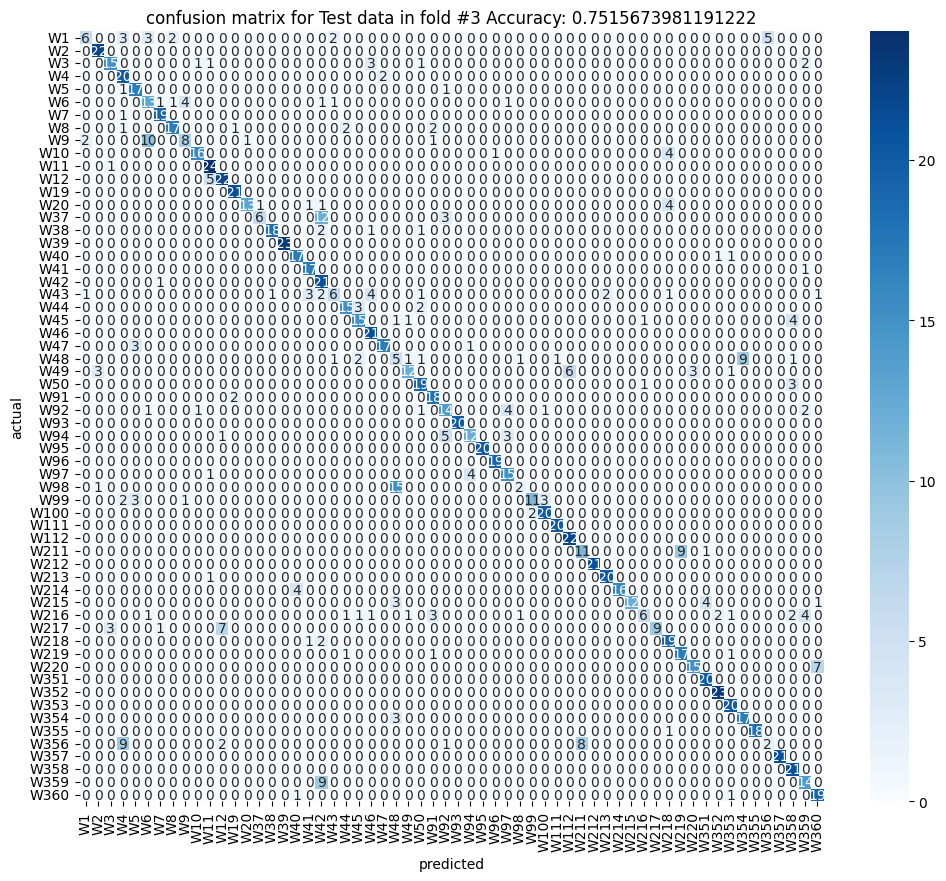

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()
